In [104]:
import pandas as pd
import calculate
import matplotlib.pyplot as plt
import numpy as np
from calculate import gini, hhi, percentage_zeros, gini_nonzero
gini_nonzero.display_name = 'Gini without zeroes'
percentage_zeros.display_name = 'Percentage of zeroes'
np.mean.display_name = 'Average'
import seaborn as sns

from credible_authors_ import DataStore

START_YEAR = 1970
LAST_START_YEAR = 2000

In [2]:
from importlib import reload
reload(calculate)

<module 'calculate' from '/home/danielkostic/cumulative-advantage/calculate.py'>

In [3]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Load data from csv

In [17]:
data_store = DataStore()
all_papers_num_cit = data_store.all_papers_num_cit

load publication data from CSV
load citation data from CSV
cited_papers_network - create
cited_papers_network - add start year
early_career_publications - create
all_papers_num_cit - create


In [4]:
author_order = pd.read_csv('derived-data/publication_authors_order_2017.csv')

### Citations and uncited papers
Dataset with all the citations to papers, together with papers that received no citations (cit_id is null)

In [20]:
uncited_papers_network = authorPublicationData.merge(data_store.authorCitationsData, left_on='pub_id',
                                                                     right_on='id2', how='left',
                                                                     suffixes=('_pub', '_cit'))

In [21]:
uncited_papers_network_first_auth = uncited_papers_network.merge(author_order[['first_author', 'pub_id']], 
                                                                 left_on=['author', 'pub_id'], 
                                                                 right_on=['first_author', 'pub_id'],how='inner')

In [23]:
uncited_papers_network_first_auth = uncited_papers_network_first_auth.merge(data_store.credible_authors[
    ['author', 'start_year']], on='author', how='left')

In [24]:
uncited_papers_network_first_auth.drop('id2', axis='columns', inplace=True)
uncited_papers_network_first_auth.rename({'id1':'cit_id'}, axis='columns', inplace=True)

In [136]:
career_len = data_store.credible_authors[['author', 'career_length']]
career_len_10 = career_len[career_len['career_length'] >= 10]

In [139]:
uncited_papers_network_first_auth_10 = uncited_papers_network_first_auth.merge(
    career_len_10['author'], how='inner', on='author')

### To remove - counts, author data, etc

In [ ]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-extended.csv')
authorStartEndCareerData.head()

In [ ]:
authorPublicationData = pd.read_csv('derived-data/author-publications.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count().reset_index()
author_year_numPub = author_year_numPub.rename(columns={'pub_id':'num_pub'})

In [ ]:
authorPublicationData.head()

Load in citation window data:

In [ ]:
WINDOW_SIZE = 3
citations_window = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}.csv')
citations_window.head()

In [ ]:
citations_window = citations_window.merge(authorStartEndCareerData[['author', 'dropped_after_10']], on='author', how='left')

In [ ]:
# citations_window[citations_window['author'] == 'ke xu']

In [ ]:
counts = citations_window

In [ ]:
years = authorStartEndCareerData['start_year'].unique()
years = sorted(years)

cohort_start_years = [year for year in years if year>=START_YEAR and year<= LAST_START_YEAR]

Is this how it's done in the other analyses?

Do this only if interested in cohorts:

In [ ]:
#counts = counts[counts['year'] <= counts['end_year']]

## Inequality of papers

In [ ]:
def plot_ineq_papers_cohort(cohort_year, years_in_future=5, career_ages=[0,1,2,5,10], func=gini,
                           data=uncited_papers_network_first_auth):
    
    uncited_papers_network_cohort = data[data['start_year'] 
                                                                          == cohort_year]
    paper_cited_list = uncited_papers_network_cohort.groupby(['year_pub', 'pub_id']).agg({'year_cit': list})
    for career_year in [cohort_year + ca for ca in career_ages]:
#         print(f"Career year {career_year}")
        paper_cited_list_year = paper_cited_list.loc[career_year]
#         print('Cited in: ', end=' ')
        for i in range(career_year,career_year+years_in_future):
            paper_cited_list_year[f'cit_in_{i}'] = paper_cited_list_year['year_cit'].apply(lambda x: sum(list(map(lambda y: 
                                                                                                                  y==i, x))))
#             print(i, end=' ')
#         print(paper_cited_list_year.columns)
        ginis = [func(paper_cited_list_year[col].astype(float).values) for col in paper_cited_list_year.columns[1:]]
#         print(ginis)
        plt.plot(ginis, label=f'{career_year-cohort_year}')
    plt.xlabel('Years after publishing')
    if func.__name__ == 'gini': 
        ylab = 'Gini in Recognition'
    else:
        ylab = func.display_name
    plt.ylabel(ylab)
    plt.legend(title='Career age when published')
    plt.title(f'Paper inequality for Cohort: {cohort_year}')
    plt.show()

### Authors with career len > 10

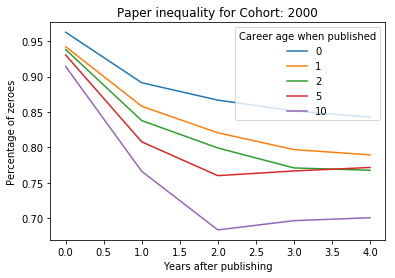

In [146]:
plot_ineq_papers_cohort(2000, 5, func=percentage_zeros, data=uncited_papers_network_first_auth_10)

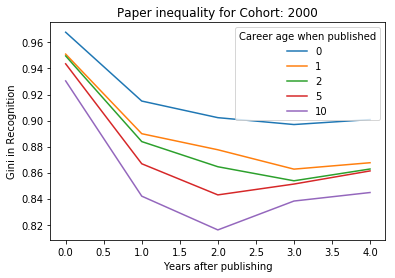

In [147]:
plot_ineq_papers_cohort(2000, 5, func=gini, data=uncited_papers_network_first_auth_10)

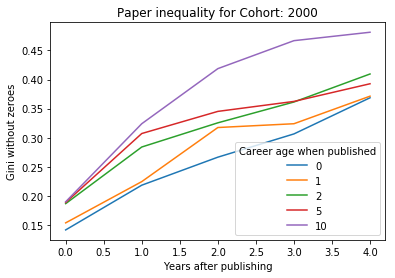

In [148]:
plot_ineq_papers_cohort(2000, 5, func=gini_nonzero, data=uncited_papers_network_first_auth_10)

### All authors

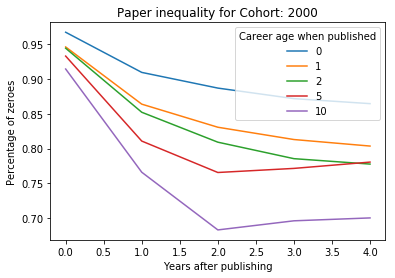

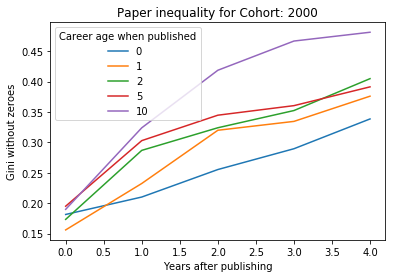

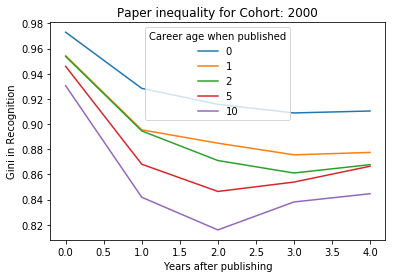

In [149]:
plot_ineq_papers_cohort(2000, 5, func=percentage_zeros)
plot_ineq_papers_cohort(2000, 5, func=gini_nonzero)
plot_ineq_papers_cohort(2000, 5, func=gini)

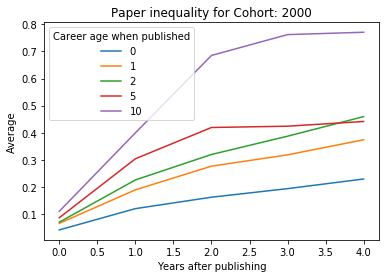

In [150]:
plot_ineq_papers_cohort(2000, 5, func=np.mean)

## Cohort Sizes

In [ ]:
cohort_sizes = counts.groupby('start_year').agg({'author': 'nunique'})

In [ ]:
def plot_cohort_size_over_years():
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.plot(cohort_sizes.index, cohort_sizes.values, linewidth=linewidth, color='black')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_yscale('log')
    ax.set_xlabel('Cohort', fontsize=fontsize)
    ax.set_ylabel('Number of Authors', fontsize=fontsize)
    #ax.set_title('', fontsize=fontsize)
    ax.set_xticks([1970, 1980, 1990, 2000])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    #ax.legend(fontsize=fontsize)
    plt.gcf().text(0., 0.9, 'A', fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig('./fig-7-notebook/cohort_size.pdf')
plot_cohort_size_over_years()

## Make plot

In [ ]:
def plot_criteria_over_career_ages(data, criteria, criteria_name, title, letter, x_start=1, x_end=15, legend=True, name_ext=''):
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    color = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
    cohort = [1970, 1975, 1980, 1985, 1990, 1995, 2000]
    for i in range(0, 7):
        df = data[data['start_year'] == cohort[i]]
        df = df[(df['career_age'] >= x_start) & (df['career_age'] <= x_end)]
        ax.plot(df['career_age'], df[criteria], linewidth=linewidth, label=cohort[i], color=color[i])
    ax.set_xlim([0.25, 15.75])
    ax.set_ylim([-0.05, 1.05])
    if 'gini' in criteria:
        ax.set_ylim([-0.05, 1.05])
    if 'hhi' in criteria:
        ax.set_ylim([-0.004, 0.074])
    if 'pzero' in criteria:
        ax.set_ylim([-0.05, 1.05])
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_xlabel('Career Age', fontsize=fontsize)
    ax.set_ylabel(f'{criteria_name}', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks([1, 5, 10, 15])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    if legend: ax.legend(fontsize=fontsize-6)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig(f'./fig-7-notebook/{criteria}{name_ext}.pdf')
    
def plot_heatmap(data, publish_years, crit):
    data_matrix = data.groupby('career_age').agg({f'ec_cit_{start}_{end}{crit}': 'mean' for start,end in publish_years})
    data_matrix[data_matrix < 0.0001] = None
    sns.heatmap(data_matrix.T[::-1], cmap="YlGnBu")

In [ ]:
def agg_data_df(citations_window, func, func_name):
    cohort_counts_ = citations_window.groupby(['start_year', 'career_age']).agg({
    'cum_num_pub':func, 'cum_num_cit':func, 'win_num_pub':func})
    # remove people not competing for attention
    cohort_counts__ = citations_window[citations_window['num_pub']>0].groupby(['start_year', 'career_age']).agg({
    'cit_3':func})
    cohort_counts_['cit_3'] = cohort_counts__['cit_3']
    cohort_counts_.reset_index(inplace=True)
    cohort_counts_ = cohort_counts_.rename({
        'cum_num_pub':f'{func_name}_cum_num_pub', 
        'cum_num_cit':f'{func_name}_cum_num_cit',
        'win_num_pub':f'{func_name}_win_num_pub',
        'cit_3': f'{func_name}_win_num_cit'
    }, axis='columns')
    return cohort_counts_

In [ ]:
def plot_array_configs(data, configs, x_end=15, name_ext=''):
    legend = True
    for config in configs:
        plot_criteria_over_career_ages(data, *config, legend=legend, x_end=x_end, name_ext=name_ext)
        legend = False

In [ ]:
def get_config1(crit, crit_name):
    config1 = [(f'{crit}_cum_num_pub', f'{crit_name} Productivity', 'Cumulative Counting', 'A'),
                (f'{crit}_cum_num_cit', f'{crit_name} Recognition', 'Cumulative Counting', 'C')]
    return config1

def get_config2(crit, crit_name):
    config2 = [(f'{crit}_win_num_pub', f'{crit_name} Productivity', 'Window Counting', 'B'),
                (f'{crit}_win_num_cit', f'{crit_name} Recognition', 'Window Counting', 'D')]
    return config2

In [ ]:
def plot_early_late_work(author_early_work, years_list, name_ext=''):
    num_iter = len(years_list)
    crits = ['_cum', '']
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    titles = ['Cum', 'Win']

    legend = True
    for i in range(0,num_iter*len(crits)):
        letter=letters[i]
        start,end = years_list[i%num_iter]
        crit = crits[i//num_iter]
        title = titles[i//num_iter]
        plot_criteria_over_career_ages(author_early_work, f'ec_cit_{start}_{end}{crit}', 'Gini Recognition', 
            title=f'{title}. (Papers of Age {start+1})', x_start=end,
            letter=letter, legend=legend, name_ext=name_ext)
        legend = False

In [ ]:
def agg_data_early_late(citations_window, func, publish_years):
    aggregate = {f'ec_cit_{start}_{end}': func for start,end in publish_years}
    aggregate.update({f'ec_cit_{start}_{end}_cum': func for start,end in publish_years})

    author_early_work = citations_window[citations_window['num_pub']>0].groupby(['start_year', 'career_age']).agg(aggregate).reset_index()
    return author_early_work

## Ginis

#### Cumulative

In [ ]:
cohort_counts_gini = agg_data_df(citations_window, gini, 'gini')

In [ ]:
cohort_counts_gini_nonzero = agg_data_df(citations_window, gini_nonzero, 'gini_nonzero')

In [ ]:
plot_array_configs(cohort_counts_gini, get_config1('gini', 'Gini'))

In [ ]:
plot_array_configs(cohort_counts_gini_nonzero, get_config1('gini_nonzero', 'Gini$_{>0}$'))

#### Time Windows

In [ ]:
plot_array_configs(cohort_counts_gini, get_config2('gini', 'Gini'), x_end=13)

In [ ]:
plot_array_configs(cohort_counts_gini_nonzero, get_config2('gini_nonzero', 'Gini$_{>0}$'), x_end=13)

#### Inequality of early vs later work

In [ ]:
# publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]
first_year = 0
publish_years = [[i, i+1] for i in range(first_year,15)]
author_gini_early_work = agg_data_early_late(citations_window, gini, publish_years)

In [ ]:
plot_heatmap(author_gini_early_work, publish_years, '_cum')

In [ ]:
plot_heatmap(author_gini_early_work, publish_years, '')

In [ ]:
years_list = [[0,1], [3,4], [6,7]]
plot_early_late_work(author_gini_early_work, years_list)

##### Cumulative recognition

In [ ]:
#cumulative
# for start,end in publish_years:
#     plot_criteria_over_career_ages(author_gini_early_work, f'ec_cit_{start}_{end}_cum', 'Recognition', 
#                                title=f'Publications of Career Ages {start+1}-{end} cumulative', 
#                                letter='', 
#                                x_start=end)

##### Non cumulative recognition

In [ ]:
#non cumulative
# for start,end in publish_years:
#     plot_criteria_over_career_ages(author_gini_early_work, f'ec_cit_{start}_{end}', 'Recognition', 
#                                title=f'Publications of Career Ages {start+1}-{end}', 
#                                letter='', 
#                                 x_start=end)

## HHI

In [ ]:
cohort_counts_hhi = agg_data_df(citations_window, hhi, 'hhi')

In [ ]:
plot_array_configs(cohort_counts_hhi, get_config1('hhi', 'HHI'))
plot_array_configs(cohort_counts_hhi, get_config2('hhi', 'HHI'), x_end=13)

## Percentage zeros

In [ ]:
cohort_counts_pzero = agg_data_df(citations_window, percentage_zeros, 'pzero')

In [ ]:
plot_array_configs(cohort_counts_pzero, get_config1('pzero', '%0'))

In [ ]:
plot_array_configs(cohort_counts_pzero, get_config2('pzero', '%0'), x_end=13)

## Remove dropouts

In [ ]:
citations_window_stayed = citations_window[citations_window.dropped_after_10 == False]

### Gini

In [ ]:
cohort_counts_stayed_gini = agg_data_df(citations_window_stayed, gini, 'gini')

In [ ]:
plot_array_configs(cohort_counts_stayed_gini, get_config1('gini', 'Gini'), name_ext='_stay') #3

In [ ]:
plot_array_configs(cohort_counts_stayed_gini, get_config2('gini', 'Gini'), x_end=13, name_ext='_stay') #3

### P zero

In [ ]:
cohort_counts_stayed_pzero = agg_data_df(citations_window_stayed, percentage_zeros, 'pzero')
plot_array_configs(cohort_counts_stayed_pzero, get_config1('pzero', '%0'), name_ext='_stay')
plot_array_configs(cohort_counts_stayed_pzero, get_config2('pzero', '%0'), x_end=13, name_ext='_stay') #plot 5

### Early vs late

In [ ]:
# publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]
publish_years = [[i, i+1] for i in range(1,15)]

author_gini_early_work_stayed = agg_data_early_late(citations_window_stayed, gini, publish_years)

In [ ]:
plot_heatmap(author_gini_early_work_stayed, publish_years, '')

In [ ]:
plot_heatmap(author_gini_early_work_stayed, publish_years, '_cum')

In [ ]:
years_list = [[0,1], [3,4], [6,7]]
plot_early_late_work(author_gini_early_work_stayed, years_list, name_ext='_stay')

In [ ]:
stop here

## Distributions

### Cohort Years
Cumulative numbers needed.

In [ ]:
start_year = 2000
career_age = 15
data = counts[(counts['start_year'] == start_year) & (counts['career_age'] == career_age)]['cum_num_pub']
data = data[data > 0]
#np.median(data)
#np.round(np.mean(data))

In [ ]:
# pdf='cum_num_pub_2000.pdf'
cars.fit_univariate(data, discrete=True, xmin=1, xlabel='p', title='2000', bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=24, unbinned_data=True, pdf=None, png=None)

In [ ]:
#guys from 2000 cohort with more than 300 papers
counts[(counts['start_year'] == 2000) & (counts['career_age'] == 15) & (counts['cum_num_pub'] > 300)][['author', 'cum_num_pub']]

### Years

In [ ]:
# publications produced between 1971 and 2014
#p = list(counts[counts['year'].between(1971, 2014)][['author', 'num_pub']].groupby('author').sum().reset_index(drop=True)['num_pub'])
# publications by all authors from cohorts 1971 to 2000 produced in their first 15 years
p = list(counts[(counts['start_year'].between(1971, 2000)) & (counts['career_age'].between(1, 15))][['author', 'num_pub']].groupby('author').sum().reset_index(drop=True)['num_pub'])
p = [int(x) for x in p if x>0]

In [ ]:
# citations received between 1971 and 2014
#c = list(counts[counts['year'].between(1971, 2014)][['author', 'num_cit']].groupby('author').sum().reset_index(drop=True)['num_cit'])
# citations received by all authors from cohorts 1971 to 2000 in their first 15 years
c = list(counts[(counts['start_year'].between(1971, 2000)) & (counts['career_age'].between(1, 15))][['author', 'num_cit']].groupby('author').sum().reset_index(drop=True)['num_cit'])
c = [int(x) for x in c if x>0]

In [ ]:
import compsoc as cs

In [ ]:
parameters_p, test_statistics_p = cs.fit_power_law(l=p, discrete=True, xmin=1, fit=None, sims=None, bootstrap=None, data_original=False, markersize=9, linewidth=2, fontsize=18, marker=0, color=1, xlabel='p', title='', legend=False, letter='', Pdf=None, png=None)

In [ ]:
parameters_c, test_statistics_c = cs.fit_power_law(l=c, discrete=True, xmin=1, fit=None, sims=None, bootstrap=None, data_original=False, markersize=9, linewidth=2, fontsize=18, marker=0, color=2, xlabel='c', title='', legend=False, letter='', Pdf=None, png=None)

In [ ]:
a_bin_p = cs.bin_pdf(cs.pdf(p))
a_bin_c = cs.bin_pdf(cs.pdf(c))

In [ ]:
import powerlaw as pl

In [ ]:
f_p = pl.Fit(p, discrete=True, xmin=1)
f_c = pl.Fit(c, discrete=True, xmin=1)

In [ ]:
space_xmin_p = np.logspace(np.log10(f_p.xmin), np.log10(max(f_p.data_original)), 100)
space_xmin_c = np.logspace(np.log10(f_c.xmin), np.log10(max(f_c.data_original)), 100)
scale_p = f_p.n_tail/len(f_p.data_original)
scale_c = f_c.n_tail/len(f_c.data_original)

In [ ]:
fontsize = 18
linewidth = 2
markersize = 9
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(111)
ax1.plot(a_bin_p[:, 0], a_bin_p[:, 3], marker='o', color='#e41a1c', ls='', markersize=markersize, label='$x=p$')
ax1.plot(a_bin_c[:, 0], a_bin_c[:, 3], marker='o', color='#377eb8', ls='', markersize=markersize, label='$x=c$')
ax1.plot(space_xmin_p, scale_p*f_p.truncated_power_law.pdf(space_xmin_p), color='k', ls='-', linewidth=linewidth)
ax1.plot(space_xmin_c, scale_c*f_c.lognormal.pdf(space_xmin_c), color='k', ls='--', linewidth=linewidth)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$x$', fontsize=fontsize)
ax1.set_ylabel('$p(x)$', fontsize=fontsize)
ax1.set_xticks([1, 10, 100, 1000, 10000])
ax1.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax1.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax1.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax1.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax1.spines['left'].set_linewidth(linewidth)
ax1.spines['right'].set_linewidth(linewidth)
ax1.spines['bottom'].set_linewidth(linewidth)
ax1.spines['top'].set_linewidth(linewidth)
ax1.legend(fontsize=fontsize-6)
plt.gcf().text(0., 0.9, 'B', fontsize=fontsize*2)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
fig.savefig('./fig-7-notebook/distributions.pdf')
plt.show()

In [ ]:
year = 2014
p = counts[counts['year'] == year]['cum_num_pub']
p = p[p > 0]
#np.median(p)
#np.round(np.mean(p))

In [ ]:
# pdf='years_cum_num_pub_2014.pdf'
cars.fit_univariate(p, discrete=True, xmin=1, xlabel='p', title=None, bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='years_cum_num_pub_2014.pdf', png='years_cum_num_pub_2014.png')

In [ ]:
pubids = authorPublicationData.pub_id.tolist()

In [ ]:
df_citations = pd.read_csv('data/paper_venue_citations.csv', sep='\t')

In [ ]:
df_citations = df_citations[df_citations.year.between(1970, 2014)]
df_citations = df_citations[df_citations.paper2.isin(pubids)]

In [ ]:
c = df_citations.groupby(['venue2']).size()

In [ ]:
### pdf='years_cum_num_cit_2014.pdf'
cars.fit_univariate(c, discrete=True, xmin=(1, 10), xlabel='c', title=None, bins=24, bootstrap=None, col=2, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='bradford_2014.pdf', png='bradford_2014.png')

## Matthew Effect

In [ ]:
# prepare output tables
micro_stats = pd.DataFrame(columns=['t', 'dt', 'author', 'eta'])
macro_stats = pd.DataFrame(columns=['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi'])
# settings
dt = 5
unit = 'num_cit' # CHANGE COLOR (1) AND LETTER (5)
fit = 'odr'
for t in range(1970+dt, 2015-dt+2): # range(1975, 2012) for dt=5
    # get vectors
    t0 = counts[counts['year'].between(t-dt, t-1)][['author', unit]].groupby('author').sum()
    t1 = counts[counts['year'].between(t, t+dt-1)][['author', unit]].groupby('author').sum()
    #t1 = counts[counts['year'].between(t, t)][['author', unit]].groupby('author').sum()
    t0 = t0[t0[unit] > 0]
    t1 = t1[t1[unit] > 0]
    # merge vectors into dataframe
    ca = pd.merge(left=t0, right=t1, left_index=True, right_index=True)
    ca.columns = ['t0', 't1']
    # fit
    df_stats, df_bootstrap = cars.fit_bivariate(ca['t0'], ca['t1'], fit=fit, reduction='bin', color=2, xlabel='c_{%.0f-%.0f}' %(t-dt, t-1), ylabel='c_{%.0f-%.0f}' %(t, t+dt-1), title='', pdf='matthew/macro_c_'+fit+'Bin_t'+str(t)+'_dt'+str(dt)+'.pdf')
    # extend micro stats (fitness)
    ca['t'] = t
    ca['dt'] = dt
    ca['author'] = ca.index
    t1_exp = df_stats['D'][0]*ca['t0']**df_stats['beta'][0]
    ca['eta'] = ca['t1']/t1_exp
    ca = ca[['t', 'dt', 'author', 'eta']]
    # extend macro stats
    df_stats['t'] = t
    df_stats['dt'] = dt
    df_stats = df_stats[['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi']]
    # append stats
    micro_stats = pd.concat([micro_stats, ca], axis=0, ignore_index=True)
    macro_stats = pd.concat([macro_stats, df_stats], axis=0, ignore_index=True)
# write output tables
micro_stats.to_csv('matthew/micro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)
macro_stats.to_csv('matthew/macro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)

### Cumulative Advantage

In [ ]:
macro_p_olsBin_dt5 = pd.read_csv('matthew/macro_p_olsBin_dt5.txt', sep='\t')
macro_c_olsBin_dt5 = pd.read_csv('matthew/macro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
macro_p_odrBin_dt5 = pd.read_csv('matthew/macro_p_odrBin_dt5.txt', sep='\t')
macro_c_odrBin_dt5 = pd.read_csv('matthew/macro_c_odrBin_dt5.txt', sep='\t')

In [ ]:
plt.fill_between(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta']-macro_p_olsBin_dt5['beta_std'], macro_p_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta']-macro_c_olsBin_dt5['beta_std'], macro_c_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Ordinary Least Squares')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

In [ ]:
plt.fill_between(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta']-macro_p_odrBin_dt5['beta_std'], macro_p_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta']-macro_c_odrBin_dt5['beta_std'], macro_c_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Orthogonal Distance Regression')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

### Fitness

In [ ]:
micro_p_olsBin_dt5 = pd.read_csv('matthew/micro_p_olsBin_dt5.txt', sep='\t')
micro_c_olsBin_dt5 = pd.read_csv('matthew/micro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
micro_p_odrBin_dt5 = pd.read_csv('matthew/micro_p_odrBin_dt5.txt', sep='\t')
micro_c_odrBin_dt5 = pd.read_csv('matthew/micro_c_odrBin_dt5.txt', sep='\t')

Users with long careers:

In [ ]:
micro_p_olsBin_dt5.groupby('author').count()

In [ ]:
#author = 'a min tjoa'
#author = 'a-nasser ansari'
#author = 'a-xing zhu'
author = 'a. a. (louis) beex'
#author = 'a. a. agboola'
#author = 'a. a. ball'
#author = 'a. a. el-bary'
#author = 'ülkü gürler'
#author = 'ülle kotta'
#author = 'ülo nurges'
#author = 'ümit aygölü'
#author = 'ümit bilge'
#author = 'ümit güz'
#author = 'ümit v. çatalyürek'
#author = 'ümit y. ogras'
#author = 'ümit özgüner'
#author = 'ünal göktas'
#author = 'ünal ufuktepe'
p = micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == author]
c = micro_c_olsBin_dt5[micro_c_olsBin_dt5['author'] == author]
plt.plot(p['t'], p['eta'], label='Productivity')
plt.plot(c['t'], c['eta'], label='Recognition')
plt.xlabel('Year')
plt.ylabel('Fitness')
plt.legend()

Lognormal fitness distributions:

In [ ]:
etaMean_p_olsBin_dt5 = micro_p_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']
etaMean_c_olsBin_dt5 = micro_c_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']

In [ ]:
print('mean:', np.mean(np.log10(etaMean_p_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_p_olsBin_dt5)))
plt.hist(np.log10(etaMean_p_olsBin_dt5))

In [ ]:
print('mean:', np.mean(np.log10(etaMean_c_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_c_olsBin_dt5)))
plt.hist(np.log10(etaMean_c_olsBin_dt5))

Correlation of productivity and recognition fitness:

In [ ]:
etaMean_olsBin_dt5 = pd.concat([etaMean_p_olsBin_dt5, etaMean_c_olsBin_dt5], axis=1)
etaMean_olsBin_dt5.columns = ['p', 'c']

In [ ]:
etaMean_olsBin_dt5.dropna(inplace=True)

In [ ]:
print('corrcoef:', np.corrcoef(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])[0, 1])
plt.scatter(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Productivity Fitness')
plt.ylabel('Mean Recognition Fitness')

## Variance of Fitness for Cohorts

In [ ]:
counts[counts['author'] == 'a. breton']

In [ ]:
micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == 'a. breton']

In [ ]:
counts_fitness_p = pd.merge(left=counts, right=micro_p_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])
counts_fitness_c = pd.merge(left=counts, right=micro_c_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])

In [ ]:
counts_fitness_p.head()

In [ ]:
counts_fitness_c.head()

Note: eta for 1975 is based on productivity in 1975-1979.

In [ ]:
counts_fitness_p_mean = counts_fitness_p.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_p_mean[counts_fitness_p_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
counts_fitness_c_mean = counts_fitness_c.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_c_mean[counts_fitness_c_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()

On average, scholars have high fitness at the beginning of their career. To which extent is the mean influenced by scholars with long careers? In other wordw, is high fitness in early years a predictor of career duration?

In [ ]:
AB HIER BAUSTELLE

In [ ]:
career_duration = [6, 10]
counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_p_mean['career_age'])

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_p_mean['career_age'], counts_fitness_p_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
career_duration = [6, 10]
counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_c_mean['career_age'])

In [ ]:
counts_fitness_c

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_c_mean['career_age'], counts_fitness_c_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()